In [1]:
import pandas as pd
import os.path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../data/250210-timeslice-chifflot-2xP100-burn300.csv')
df.reset_index(inplace=True)

drop_everything_before_measure = '1|0'

timestamp_decrease = df.timestamp.diff() < 0
restart = timestamp_decrease[timestamp_decrease].index.values
range_start = df.loc[df['measure'] == drop_everything_before_measure].iloc[0].values[0].astype(int)
frames = []
for range_end in restart:
    if range_start>0:
        frames.append(df[range_start:range_end].pivot(index=['timestamp','domain'], columns='metric', values='measure').reset_index())
    range_start = range_end
frames.append(df[range_start:].pivot(index=['timestamp','domain'], columns='metric', values='measure').reset_index())

dataset = pd.concat(frames)
dataset.set_index(['timestamp','domain', 'CONST_context'], inplace=True)
dataset_keys = list(dataset.keys())
if 'SMI_PSTATE' in dataset_keys: dataset_keys.remove('SMI_PSTATE')
if 'SMI_pstate' in dataset_keys: dataset_keys.remove('SMI_pstate')
dataset = dataset.astype({key:'float' for key in dataset_keys})
dataset.reset_index(inplace=True)

dataset = dataset.drop(dataset.loc[dataset['timestamp'] > 280 ].index)
dataset = dataset.drop(dataset.loc[dataset['timestamp'] < 30 ].index)

In [3]:
dataset_domains = dataset.drop(dataset.loc[dataset['domain'].isin(['GPU-X', 'global'])].index)
dataset_domains['oversubscription'] = dataset_domains['CONST_context'].apply(lambda x : x.split('|')[0])
dataset_domains['instances'] = dataset_domains['CONST_context'].apply(lambda x : x.split('|')[1])

In [7]:
sns.color_palette("Set2")
sns.set_theme(style="darkgrid")

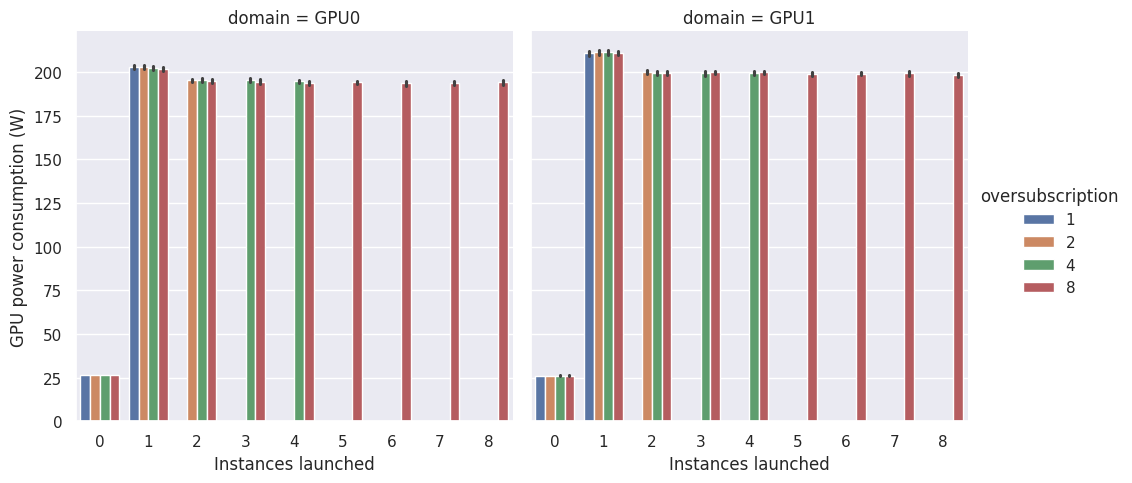

In [12]:
g = sns.catplot(data=dataset_domains, x='instances', y='SMI_power.draw', hue='oversubscription', col='domain', kind="bar", sharey=True)
g.set_axis_labels("Instances launched", "GPU power consumption (W)")
plt.gcf().savefig('figures/TS-power.pdf', bbox_inches='tight')